In [1]:
import joblib
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import stylia

DATA_PATH = "../data"


In [3]:
result = joblib.load("../data/protein_precalcs_only_aucs.joblib")
x = []
y = []
n_pos = []
for r in result:
    if r["auroc"][0] is not None:
        x += [r["auroc_baseline"][0]]
        y += [r["auroc"][0]]
        n_pos += [r["n_pos"]]
x = np.array(x)
y = np.array(y)
n_pos = np.array(n_pos)

In [32]:
len(x)

64

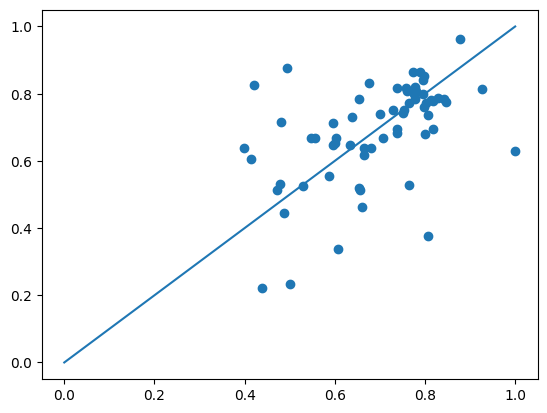

In [33]:
plt.scatter(x,y)
plt.plot([0,1], [0,1])

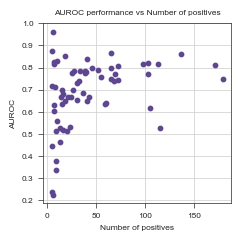

In [9]:
fig, axs = stylia.create_figure(1,1, width=stylia.TWO_COLUMNS_WIDTH/3, height=stylia.TWO_COLUMNS_WIDTH/3)
ax = axs.next()
ax.scatter(n_pos, y)
stylia.label(ax=ax, title="AUROC performance vs Number of positives", xlabel="Number of positives", ylabel="AUROC")
stylia.save_figure("../assets/AUROC_vs_positives.png")

In [38]:
np.median(y), np.median(x)

(0.7231562703053931, 0.7328412167542602)

In [52]:
from fragmentembedding import FragmentEmbedder

fe = FragmentEmbedder()
fe.transform(smiles)

/Users/mduranfrigola/miniconda3/envs/onthefly/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator VarianceThreshold from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mduranfrigola/miniconda3/envs/onthefly/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator VarianceThreshold from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mduranfrigola/miniconda3/envs/onthefly/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unp

array([[ 0.4275 , -0.2642 , -0.243  , ..., -0.1736 ,  0.2369 , -0.04938],
       [ 0.856  , -0.2537 ,  0.10284, ...,  0.08325, -0.06152,  0.2607 ],
       [ 1.499  , -0.2734 ,  0.1271 , ..., -0.2732 , -0.1918 , -0.2783 ],
       ...,
       [ 0.86   , -0.2776 ,  0.566  , ..., -0.2686 , -0.091  , -0.1276 ],
       [ 2.246  , -0.2341 , -0.2727 , ...,  0.155  , -0.2479 , -0.03134],
       [ 2.111  , -0.2474 , -0.2783 , ..., -0.2416 ,  0.2769 ,  0.07086]],
      dtype=float16)

In [61]:
fid2smi = pd.read_csv(os.path.join(DATA_PATH, "cemm_smiles.csv"))

fe = FragmentEmbedder()

print(list(fid2smi["smiles"]))

X = fe.transform(list(fid2smi["smiles"]))
print(X)

/Users/mduranfrigola/miniconda3/envs/onthefly/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator VarianceThreshold from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mduranfrigola/miniconda3/envs/onthefly/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator VarianceThreshold from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mduranfrigola/miniconda3/envs/onthefly/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unp

['C#CCCC1(CCC(=O)NC2(CCO)CS(=O)(=O)C2)N=N1', 'C#CCCC1(CCC(=O)NC(C(N)=O)c2ccc3ccccc3c2)N=N1', 'C#CCCC1(CCC(=O)Nc2ccc(-c3cn4cccc(C)c4n3)cc2)N=N1', 'C#CCCC1(CCNC(=O)c2cc(=O)[nH]c(C3CCOCC3)n2)N=N1', 'C#CCCC1(CCNC(=O)CC2CS(=O)(=O)c3ccccc3O2)N=N1', 'C#CCCC1(CCNC(=O)c2c[nH]c(C(C)(C)C)n2)N=N1', 'C#CCCC1(CCNC(=O)CC2(C(F)(F)F)CCC(=O)NC2)N=N1', 'C#CCCC1(CCC(=O)Nc2cc(CCc3ccccc3C)n[nH]2)N=N1', 'C#CCCC1(CCNC(=O)c2c(C(F)(F)F)nc3n2CCCC3)N=N1', 'C#CCCC1(CCNC(=O)c2cc(OC)c3c(c2)OCCO3)N=N1', 'C#CCCC1(CCNC(=O)c2ncsc2S(N)(=O)=O)N=N1', 'C#CCCC1(CCNC(=O)c2ccc(S(=O)(=O)c3ccccc3)s2)N=N1', 'C#CCCC1(CCC(=O)NC(Cc2ccccn2)C2COc3ccccc3O2)N=N1', 'C#CCCC1(CCC(=O)Nc2ccc3c(c2)nc(C)n3C2(CO)CCC2)N=N1', 'C#CCCC1(CCC(=O)N2CCCN(S(=O)(=O)c3ccc(Cl)s3)CC2)N=N1', 'C#CCCC1(CCNC(=O)C2=NN(c3ccc(F)cc3)C(C(N)=O)C2)N=N1', 'C#CCCC1(CCC(=O)N2C[C@H]3CN(C)CC[C@@]3(CO)C2)N=N1', 'C#CCCC1(CCC(=O)NCCS(=O)(=O)N2CCOCC2)N=N1', 'C#CCCC1(CCC(=O)N2CCC3(CC2)OCc2ccncc23)N=N1', 'C#CCCC1(CCC(=O)NC2CCc3cccc4cccc2c34)N=N1', 'C#CCCC1(CCC(=O)Nc2cc(C3CC3)nn2

100%|██████████| 407/407 [00:03<00:00, 119.42it/s]

[[ 0.4275  -0.2642  -0.243   ... -0.1736   0.2369  -0.04938]
 [ 0.856   -0.2537   0.10284 ...  0.08325 -0.06152  0.2607 ]
 [ 1.499   -0.2734   0.1271  ... -0.2732  -0.1918  -0.2783 ]
 ...
 [ 0.86    -0.2776   0.566   ... -0.2686  -0.091   -0.1276 ]
 [ 2.246   -0.2341  -0.2727  ...  0.155   -0.2479  -0.03134]
 [ 2.111   -0.2474  -0.2783  ... -0.2416   0.2769   0.07086]]


In [56]:
X

array([[ 0.4275 , -0.2642 , -0.243  , ..., -0.1736 ,  0.2369 , -0.04938],
       [ 0.856  , -0.2537 ,  0.10284, ...,  0.08325, -0.06152,  0.2607 ],
       [ 1.499  , -0.2734 ,  0.1271 , ..., -0.2732 , -0.1918 , -0.2783 ],
       ...,
       [ 0.86   , -0.2776 ,  0.566  , ..., -0.2686 , -0.091  , -0.1276 ],
       [ 2.246  , -0.2341 , -0.2727 , ...,  0.155  , -0.2479 , -0.03134],
       [ 2.111  , -0.2474 , -0.2783 , ..., -0.2416 ,  0.2769 ,  0.07086]],
      dtype=float16)

In [38]:
%%time

class BinaryBalancer(object):
    def __init__(self, proportion=0.5, n_samples=1000):
        self.proportion = proportion
        self.n_samples = n_samples

    def _resample(self, X, size, weights):
        idxs = [i for i in range(X.shape[0])]
        sampled_idxs = np.random.choice(idxs, size=(size - X.shape[0]), replace=True, p=weights)
        X_s = X[sampled_idxs]
        nn = NearestNeighbors(n_neighbors=4)
        nn.fit(X)
        neighs = nn.kneighbors(X_s, return_distance=False)[:, 1:]
        R = []
        w = np.array([0.75, 0.5, 0.25])
        w /= w.sum()
        for i in range(X_s.shape[0]):
            gap = random.random()
            j = int(np.random.choice([0, 1, 2], p=w))
            neigh_idx = neighs[i,j]
            d = X[neigh_idx] - X_s[i]
            R += [X_s[i] + gap*d]
        X_s = np.array(R)
        X = np.vstack([X, X_s])
        return X

    def transform(self, X, y, sample_weights=None):
        X = np.array(X)
        y = np.array(y)
        X_0 = X[y == 0]
        X_1 = X[y == 1]
        num_0_samples = int(self.n_samples*(1 - self.proportion))
        num_1_samples = int(self.n_samples*self.proportion)
        if sample_weights is None:
            sample_weights = np.array([1.]*X.shape[0])
        else:
            sample_weights = np.array(sample_weights)
        weights_0 = sample_weights[y == 0]
        weights_1 = sample_weights[y == 1]
        weights_0 = weights_0 / weights_0.sum()
        weights_1 = weights_1 / weights_1.sum()
        X_0 = self._resample(X_0, num_0_samples, weights_0)
        X_1 = self._resample(X_1, num_1_samples, weights_1)
        X = np.vstack([X_0, X_1])
        y = np.array([1]*X_0.shape[0] + [0]*X_1.shape[0])
        idxs = [i for i in range(len(y))]
        random.shuffle(idxs)
        X = X[idxs]
        y = y[idxs]
        return X, y
    
balancer = BinaryBalancer(0.5)
balancer.transform(X, y)

CPU times: user 85.1 ms, sys: 70.4 ms, total: 156 ms
Wall time: 20.5 ms


(array([[-0.2367 ,  3.15   ,  0.332  , ...,  1.206  ,  1.879  ,  0.671  ],
        [-0.2708 ,  0.9556 , -0.1537 , ...,  0.7373 ,  2.055  ,  0.7256 ],
        [ 2.084  , -0.02942, -0.2305 , ...,  1.061  , -0.11847,  1.535  ],
        ...,
        [ 3.053  ,  0.12256, -0.268  , ...,  0.4453 ,  0.01611,  0.6475 ],
        [-0.1337 ,  0.0523 ,  1.02   , ..., -0.1951 ,  0.5938 , -0.1895 ],
        [ 0.6416 , -0.2424 ,  0.03955, ...,  0.602  , -0.2583 ,  1.117  ]],
       dtype=float16),
 array([1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0

In [42]:
from fragmentembedding import FragmentEmbedder

fe = FragmentEmbedder()
fe.transform(fids)

/Users/mduranfrigola/miniconda3/envs/onthefly/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator VarianceThreshold from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mduranfrigola/miniconda3/envs/onthefly/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator VarianceThreshold from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mduranfrigola/miniconda3/envs/onthefly/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unp

array([[ 1.4619e+00, -2.7173e-01, -2.3633e-01, -6.2256e-03, -2.4561e-01,
        -1.6663e-01,  6.5674e-01,  2.9810e-01, -2.7539e-01, -1.0272e-01,
        -1.8323e-01,  5.4297e-01, -2.1692e-01,  2.7417e-01, -2.7026e-01,
        -2.4915e-01,  1.7842e+00,  1.0117e+00,  1.5161e-01, -1.5100e-01,
         1.6321e-01, -2.6245e-01,  2.4561e-01, -1.3916e-01,  4.7607e-01,
         3.4546e-02,  6.4355e-01, -2.7832e-01,  6.6846e-01, -5.3223e-02,
         2.6904e-01, -2.7832e-01,  2.8229e-02,  2.0938e+00,  1.5557e+00,
         1.5078e+00,  5.5029e-01, -2.7856e-01, -2.7271e-01,  1.0371e+00,
         4.0845e-01, -2.5342e-01, -2.3743e-01, -2.6758e-01,  3.9526e-01,
        -6.6406e-02, -1.4478e-01,  1.4785e+00,  1.0859e+00,  3.1665e-01,
        -2.1655e-01, -6.7200e-02,  8.7036e-02, -1.8616e-01, -1.8738e-01,
         2.4902e-01,  1.5930e-01, -2.4146e-01, -2.7734e-01, -1.4575e-01,
         4.1748e-01,  8.4900e-02,  6.5771e-01, -2.7759e-01, -1.7358e-01,
         6.2256e-01, -1.7834e-01, -1.1856e-02,  1.5